##Clone SrdyPy from git

In [ ]:
!rm -rf SrdPy
!git clone https://github.com/RumblingTurtle/SrdPy.git

Cloning into 'SrdPy'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (373/373), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 373 (delta 172), reused 297 (delta 96), pack-reused 0
Receiving objects: 100% (373/373), 4.04 MiB | 3.32 MiB/s, done.
Resolving deltas: 100% (172/172), done.


##Clone colab compatible meshcat repo and install casadi

In [ ]:
!pip install git+https://github.com/rdeits/meshcat-python.git@master
!pip install casadi
!pip install control
!pip install slycot
!pip install urdf-parser-py
!pip install pyngrok

  Cloning https://github.com/rdeits/meshcat-python.git (to revision master) to /tmp/pip-req-build-va_rbb_e
  Running command git clone -q https://github.com/rdeits/meshcat-python.git /tmp/pip-req-build-va_rbb_e
  Running command git submodule update --init --recursive -q
  Created wheel for meshcat: filename=meshcat-0.0.19-cp36-none-any.whl size=627628 sha256=11445a2b403a8a0ad1d3affa6a1621dcd827ae888eb43574e1164965afe9e007
  Stored in directory: /tmp/pip-ephem-wheel-cache-h0zl2b98/wheels/c2/57/90/f09f46ded98f6ea0f4dd05029529fe8d24d936a520786a60e0
Successfully built meshcat


In [ ]:
from SrdPy.LinksAndJoints import *
from SrdPy.Handlers import *
from SrdPy.InverseKinematics import *
from SrdPy.SymbolicUtils import *
from SrdPy.Loggers import *
from SrdPy.DynamicSolvers import *
from SrdPy.Controllers import *
from SrdPy import SymbolicEngine
from SrdPy.Visuals import Visualizer
from casadi import *
from copy import deepcopy
from SrdPy import Chain
import numpy as np
import os
import time

##Import a robot from URDF file

In [ ]:
from SrdPy.URDFUtils import getLinkArrayFromURDF

iiwaLinks = getLinkArrayFromURDF("./SrdPy/iiwa/iiwa14.urdf",True)
iiwaChain = Chain(iiwaLinks)
iiwaChain.update(np.array([1]*7))
vis = Visualizer()
vis.show(iiwaChain,True)

Unknown tag: material
Unknown tag: self_collision_checking
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface


You can open the visualizer by visiting the following URL:
http://0327d338343f.ngrok.io/static/


##Or define it yourself

In [ ]:
groundLink = GroundLink()

link1 = Link(name="Link1", order=1, inertia=np.diag([1/12*10*0.5, 1/12*10*0.5, 0.1*1/12*10*0.5]), mass=1,
                relativeBase=[0, 0, 0], relativeFollower=[[0, 0, 0.5]], relativeCoM=[0, 0, 0.25])

link2 = Link(name="Link2", order=1, inertia=np.diag([1/12*10*0.5, 1/12*10*0.5, 0.1*1/12*10*0.5]), mass=1,
                relativeBase=[0, 0, 0], relativeFollower=[[0, 0, 0.5]], relativeCoM=[0, 0, 0.25])

link3 = Link(name="Link3", order=1, inertia=np.diag([1/12*10*0.5, 1/12*10*0.5, 0.1*1/12*10*0.5]), mass=1,
                relativeBase=[0, 0, 0], relativeFollower=[[0, 0, 0.5]], relativeCoM=[0, 0, 0.25])


##Define joints connecting the links

In [ ]:
genCoordIndex = 0

newCoordIndices = [0]
jointGto1 = JointPivotX(name="GroundToFirst", childLink=link1, parentLink=groundLink, parentFollowerNumber=0,
                          usedGeneralizedCoordinates=newCoordIndices, usedControlInputs=newCoordIndices,
                          defaultJointOrientation=np.eye(3))

newCoordIndices = [1]
joint1to2 = JointPivotX(name="1To2", childLink=link2, parentLink=link1, parentFollowerNumber=0,
                            usedGeneralizedCoordinates=newCoordIndices, usedControlInputs=newCoordIndices,
                            defaultJointOrientation=np.eye(3))

newCoordIndices = [2]
joint2to3 = JointPivotX(name="2To3", childLink=link3, parentLink=link2, parentFollowerNumber=0,
                            usedGeneralizedCoordinates=newCoordIndices, usedControlInputs=newCoordIndices,
                            defaultJointOrientation=np.eye(3))


##Create a chain and update joint positions

In [ ]:
initialPosition = np.array([np.pi/4, -2*np.pi/3, 1*np.pi/5])
linkArray = [groundLink, link1, link2, link3]

chain = Chain(linkArray)
blank_chain = deepcopy(chain)
blank_chain.update(initialPosition)

##Display robot

In [ ]:
vis = Visualizer()
vis.show(blank_chain)

You can open the visualizer by visiting the following URL:
http://17d3e5b6229a.ngrok.io/static/


##Define dynamics constraints

In [ ]:
engine = SymbolicEngine(chain.linkArray)
deriveJacobiansForlinkArray(engine)
H = deriveJSIM(engine)

iN, dH = deriveGeneralizedInertialForces_dH(engine,H)
g = deriveGeneralizedGravitationalForces(engine)
d = deriveGeneralizedDissipativeForcesUniform(engine, 1)

#NaiveControlMap
T = deriveControlMap(engine)

description_gen_coord_model = generateDynamicsGeneralizedCoordinatesModel(engine,
                                            H=H,
                                            c=(iN+g+d),
                                            T=T,
                                            functionName_H="g_dynamics_H",
                                            functionName_c="g_dynamics_c",
                                            functionName_T="g_dynamics_T",
                                            casadi_cCodeFilename="g_dynamics_generalized_coordinates",
                                            path="./Dynamics")

handlerGeneralizedCoordinatesModel = getGeneralizedCoordinatesModelHandlers(description_gen_coord_model)


description_linearization = generateDynamicsLinearization(engine,
                                            H=H,
                                            c=(iN + g + d),
                                            T=T,
                                            functionName_A="g_linearization_A",
                                            functionName_B="g_linearization_B",
                                            functionName_c="g_linearization_c",
                                            casadi_cCodeFilename="g_dynamics_linearization",
                                            path="./Linearization")
handlerLinearizedModel = getLinearizedModelHandlers(description_linearization)

constraint = engine.linkArray[3].absoluteFollower[0][2]

description_constraints = generateSecondDerivativeJacobians(engine,
                                                            task=constraint,
                                                            functionName_Task="g_Constraint",
                                                            functionName_TaskJacobian="g_Constraint_Jacobian",
                                                            functionName_TaskJacobianDerivative="g_Constraint_Jacobian_derivative",
                                                            casadi_cCodeFilename="g_Constraints",
                                                            path="./Constraints")
handlerConstraints = getConstraintsModelHandlers(description_constraints,engine.dof)


task = vertcat(vertcat(engine.q[0], engine.q[1]), constraint)

description_IK = generateSecondDerivativeJacobians(engine,
                                                            task=task,
                                                            functionName_Task="g_InverseKinematics_Task",
                                                            functionName_TaskJacobian="g_InverseKinematics_TaskJacobian",
                                                            functionName_TaskJacobianDerivative="g_InverseKinematics_TaskJacobian_derivative",
                                                            casadi_cCodeFilename="g_InverseKinematics",
                                                            path="./InverseKinematics")


(3, 1)
Starting writing function for the g_dynamics_H
Starting writing function for the g_dynamics_c
Starting writing function for the g_dynamics_T
Running gcc -fPIC -shared g_dynamics_generalized_coordinates.c -o g_dynamics_generalized_coordinates.so
Generated C code!
Starting writing function for the g_linearization_A
Starting writing function for the g_linearization_B
Starting writing function for the g_linearization_c
Running gcc -fPIC -shared g_dynamics_linearization.c -o g_dynamics_linearization.so
Generated C code!
Starting writing function for the g_Constraint
Starting writing function for the g_Constraint task jacobian
Starting writing function for the derivative of g_Constraint
Running gcc -fPIC -shared g_Constraints.c -o g_Constraints.so
Generated C code!
Starting writing function for the g_InverseKinematics_Task
Starting writing function for the g_InverseKinematics_Task task jacobian
Starting writing function for the derivative of g_InverseKinematics_Task
Running gcc -fPIC 

##IK task design

In [ ]:
IKModelHandler = getIKModelHandler(description_IK, engine.dof, task.shape[0])
IC_task = IKModelHandler.getTask(initialPosition)

zeroOrderDerivativeNodes = [[IC_task[0], IC_task[0]],
                            [IC_task[1], IC_task[1]+0.15],
                            [IC_task[2], IC_task[2]-0.15]]

firstOrderDerivativeNodes = [[0, 0],
                              [0, 0],
                              [0, 0]]

secondOrderDerivativeNodes = [[0, 0],
                              [0, 0],
                              [0, 0]]

timeOfOneStage = 2
timeEnd = (len(zeroOrderDerivativeNodes[1]) - 1)*timeOfOneStage+1
nodeTimes = np.arange(start=0,stop=timeEnd,step=timeOfOneStage)

handlerIK_taskSplines = getIKtaskSplinesHandler(nodeTimes,
                                                  zeroOrderDerivativeNodes,firstOrderDerivativeNodes,secondOrderDerivativeNodes)

timeTable = np.arange(handlerIK_taskSplines.timeStart,handlerIK_taskSplines.timeExpiration+0.01,0.01)
IKTable = inverseKinematicsGenerateTable(IKModelHandler, handlerIK_taskSplines, initialPosition, timeTable)

IKSolutionHandler = getIKSolutionHandler(IKModelHandler, handlerIK_taskSplines, timeTable, IKTable, "linear")

Calculating  0.0%
Calculating  0.0%
Calculating  1.0%
Calculating  2.0%
Calculating  3.0%
Calculating  4.0%
Calculating  5.0%
Calculating  6.0%
Calculating  7.0%
Calculating  8.0%
Calculating  9.0%
Calculating  10.0%
Calculating  11.0%
Calculating  12.0%
Calculating  13.0%
Calculating  14.0%
Calculating  15.0%
Calculating  16.0%
Calculating  17.0%
Calculating  18.0%
Calculating  19.0%
Calculating  20.0%
Calculating  21.0%
Calculating  22.0%
Calculating  23.0%
Calculating  24.0%
Calculating  25.0%
Calculating  26.0%
Calculating  27.0%
Calculating  28.0%
Calculating  29.0%
Calculating  30.0%
Calculating  31.0%
Calculating  32.0%
Calculating  33.0%
Calculating  34.0%
Calculating  35.0%
Calculating  36.0%
Calculating  37.0%
Calculating  38.0%
Calculating  39.0%
Calculating  40.0%
Calculating  41.0%
Calculating  42.0%
Calculating  43.0%
Calculating  44.0%
Calculating  45.0%
Calculating  46.0%
Calculating  47.0%
Calculating  48.0%
Calculating  49.0%
Calculating  50.0%
Calculating  51.0%
Calc

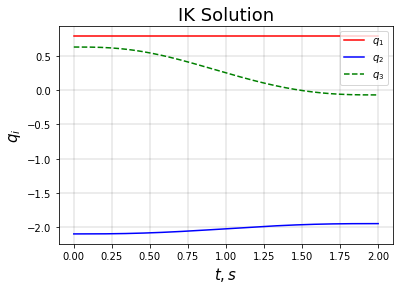

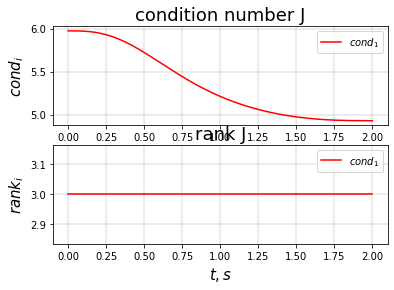

In [ ]:
inversekinematicsGenerateTableTester(IKModelHandler, timeTable, IKTable )

##Simulation

In [ ]:
stateHandler = getStateHandler(initialPosition,np.zeros(len(initialPosition)))
gcModelEvaluator = getGCModelEvaluatorHandler(handlerGeneralizedCoordinatesModel,stateHandler)
linearModelEvaluator = getLinearModelEvaluatorHandler(handlerGeneralizedCoordinatesModel,handlerLinearizedModel,stateHandler,[],False)

dt = 0.001
tf = IKSolutionHandler.timeExpiration


simulationHandler = getSimulationHandler(np.arange(0,tf,dt))

desiredStateHandler = getDesiredStateHandler(IKSolutionHandler,simulationHandler)

stateSpaceHandler = getStateConverterGenCoord2StateSpaceHandler(stateHandler)

desiredStateSpaceHandler = getStateConverterGenCoord2StateSpaceHandler(desiredStateHandler)

inverseDynamicsHandler = getIDVanillaDesiredTrajectoryHandler(desiredStateHandler,gcModelEvaluator,simulationHandler)

computedTorqueController = getComputedTorqueController(stateHandler,desiredStateHandler,
                                                        gcModelEvaluator,simulationHandler,inverseDynamicsHandler,
                                                        500*np.eye(desiredStateHandler.dofRobot),100*np.eye(desiredStateHandler.dofRobot))

LQRHandler = getLQRControllerHandler(stateSpaceHandler, desiredStateSpaceHandler, linearModelEvaluator,simulationHandler,
                                      inverseDynamicsHandler,10*np.eye(linearModelEvaluator.dofRobotStateSpace),np.eye(linearModelEvaluator.dofControl))

mainController = LQRHandler

linearModelEvaluator.controllerHandler = inverseDynamicsHandler

taylorSolverHandler = getTaylorSolverHandler(stateHandler,mainController, gcModelEvaluator,simulationHandler)

stateHandlerLogger = getStateLoggerHandler(stateHandler,simulationHandler)

tickLogger = getProgressDisplayHandler(simulationHandler)

preprocessingHandlers = [desiredStateHandler, stateSpaceHandler, desiredStateSpaceHandler, gcModelEvaluator, linearModelEvaluator]
controllerHandlers = [inverseDynamicsHandler,LQRHandler]
solverHandlers = [taylorSolverHandler]
loggerHandlers = [stateHandlerLogger,tickLogger]

simulationHandler.preprocessingHandlersArray = preprocessingHandlers
simulationHandler.controllerArray = controllerHandlers
simulationHandler.solverArray = solverHandlers
simulationHandler.loggerArray = loggerHandlers

simulationHandler.simulate()

Simulated 0 out of 2000 steps
Simulated 1 out of 2000 steps
Simulated 2 out of 2000 steps
Simulated 3 out of 2000 steps
Simulated 4 out of 2000 steps
Simulated 5 out of 2000 steps
Simulated 6 out of 2000 steps
Simulated 7 out of 2000 steps
Simulated 8 out of 2000 steps
Simulated 9 out of 2000 steps
Simulated 10 out of 2000 steps
Simulated 11 out of 2000 steps
Simulated 12 out of 2000 steps
Simulated 13 out of 2000 steps
Simulated 14 out of 2000 steps
Simulated 15 out of 2000 steps
Simulated 16 out of 2000 steps
Simulated 17 out of 2000 steps
Simulated 18 out of 2000 steps
Simulated 19 out of 2000 steps
Simulated 20 out of 2000 steps
Simulated 21 out of 2000 steps
Simulated 22 out of 2000 steps
Simulated 23 out of 2000 steps
Simulated 24 out of 2000 steps
Simulated 25 out of 2000 steps
Simulated 26 out of 2000 steps
Simulated 27 out of 2000 steps
Simulated 28 out of 2000 steps
Simulated 29 out of 2000 steps
Simulated 30 out of 2000 steps
Simulated 31 out of 2000 steps
Simulated 32 out o

In [ ]:
vis = Visualizer()
vis.animate(blank_chain,stateHandlerLogger.q,framerate=0.1)

You can open the visualizer by visiting the following URL:
http://a477543a7d89.ngrok.io/static/


##Plot optimized variables

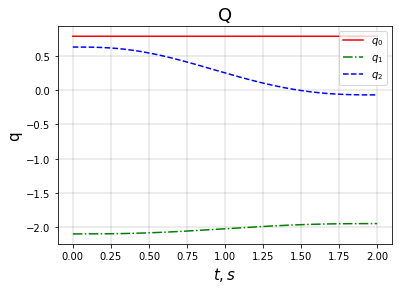

In [ ]:
from SrdPy import plotGeneric
plotGeneric(simulationHandler.timeLog[:-1],stateHandlerLogger.q,figureTitle="Q",ylabel="q")

In [ ]:
plotGeneric(simulationHandler.timeLog[:-1], stateHandlerLogger.v, figureTitle="V", ylabel="v")